In [11]:
### import libraries
from sklearn.cluster import SpectralClustering
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
from adjustText import adjust_text
from node2vec import Node2Vec
from gensim import models
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from gensim.models import Word2Vec

In [2]:
# read data
raw_data = pd.read_csv('./Data/associations.csv', squeeze=True, sep="\a")
df = raw_data.str.split(",", n=-1, expand=True)
df.columns = ['from', 'to', 'weight', 'weight1']
df = df.drop('weight1', axis=1)

## delete numbers
df[['from', 'to']] = df[['from', 'to']].replace('\d+', '', regex=True)
df = df[df['from'].astype(bool)]                                                                                                                  
df = df[df['to'].astype(bool)]   


#specify types
df = df.astype(str)
df['weight'] = pd.to_numeric(df['weight'])

In [3]:
df

,from,to,weight
0,Rockwell Extra Bold,Hiragino Kaku Gothic ProN,0.082500
1,Raise,Center,0.085556
2,Rockwell,Hiragino Sans GB,0.066000
3,Zapfino,Harrington,0.110000
4,MingLiU_HKSCS-ExtB,Didot,0.082500
...,...,...,...
111823,Bookman Old Style,Impact,0.082500
111824,Loosen,Jump to Selection,0.020625
111825,MS PGothic,Sinhala Sangam MN,0.110000
111826,Ctrl+Shift+F,Shift+Insert,0.110000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109676 entries, 0 to 111827
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   from    109676 non-null  object 
 1   to      109676 non-null  object 
 2   weight  109676 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.3+ MB


In [5]:
'''Graph creation and initialization'''
# default edge weight=1
G=nx.from_pandas_edgelist(df, 'from', 'to', ['weight'])

'''Matrix creation'''
adj_matrix = nx.to_numpy_matrix(G) #Converts graph to an adj matrix with adj_matrix[i][j] represents weight between node i,j.
nodes_list = list(G.nodes()) #returns a list of nodes with index mapping with the a 
number_of_nodes = len(nodes_list)
nodes_list_index = list(range(number_of_nodes))
n_clusters = int(np.ceil(np.log2(number_of_nodes)))

In [6]:
3120 * 3119 /2

4865640.0

In [1]:
# Generate walks
node2vec = Node2Vec(G, dimensions=300, walk_length=8, num_walks=100, workers= 6)

# Learn embeddings 
model = node2vec.fit(window=5, min_count=1)

In [82]:
# model.save('./d300-walk8-numwalk100-window5-mincount1.model')

In [12]:
# model = Word2Vec.load('./d300-walk8-numwalk100-window5-mincount1.model')

In [13]:
model.wv.get_vector('Save')

array([ 0.14552128,  0.04760363, -0.3765238 ,  0.18956931, -0.18622833,
       -0.3934443 ,  0.36521018,  0.7125185 ,  0.20290121, -0.2090193 ,
       -0.06515123, -0.06327401, -0.21724474,  0.0665441 , -0.23243625,
       -0.0641624 ,  0.05303654, -0.21025851,  0.24622688, -0.18654767,
        0.0684393 , -0.08230777,  0.14206645,  0.28345084,  0.38351363,
       -0.13790102,  0.1262622 , -0.17481895, -0.20000157,  0.18632142,
        0.3083576 , -0.12715542, -0.15793489, -0.09931489, -0.03279109,
        0.07141069,  0.0628523 ,  0.15913315,  0.15668194, -0.22409627,
       -0.3732857 ,  0.06334587, -0.1294119 , -0.10075967,  0.20552802,
        0.12181765, -0.10356852,  0.22269103, -0.14844404,  0.02788368,
        0.13760336,  0.13211586, -0.3604703 , -0.002825  ,  0.01080716,
        0.10005925,  0.26320595, -0.09230057,  0.06818524, -0.1639216 ,
       -0.40092453, -0.16786247,  0.02518487,  0.13162579,  0.15724337,
        0.02801942, -0.3012273 , -0.08056314, -0.32400453, -0.28

In [14]:
# word similarity function 
def wordsim(word1,word2):
    word1 = model.wv.get_vector(word1).reshape(1,-1)
    word2 = model.wv.get_vector(word2).reshape(1,-1)
    return cosine_similarity(word1,word2)

In [15]:
wordsim('Trace Dependents', 'Trace Error')

array([[0.9926146]], dtype=float32)

In [16]:
model.wv.most_similar('New Tab', topn=20)  # <=== note the .wv

[('Export Bookmarks', 0.9525933861732483),
 ('Open in Dashboard', 0.9520044326782227),
 ('Mail Link to This Page', 0.9473936557769775),
 ('Mail Contents of This Page', 0.9416106939315796),
 ('Import Bookmarks', 0.9388823509216309),
 ('Open File', 0.8905087113380432),
 ('Open Location', 0.857744038105011),
 ('Close Other Tabs', 0.8564198017120361),
 ('Close All Windows', 0.855567991733551),
 ('Close Tab', 0.8470062017440796),
 ('Advanced Open File', 0.8184773921966553),
 ('Open Capture Device', 0.8011445999145508),
 ('Open Disc', 0.7950068712234497),
 ('Streaming/Exporting Wizard', 0.782598614692688),
 ('New Window', 0.7793950438499451),
 ('Open Network', 0.7786928415298462),
 ('Open VIDEO_TS', 0.7667489051818848),
 ('Save Playlist', 0.7663076519966125),
 ('Open Subtitle', 0.7658212184906006),
 ('Open Dictionaries Folder', 0.7608514428138733)]

In [80]:
# Case Study: Notepad

5

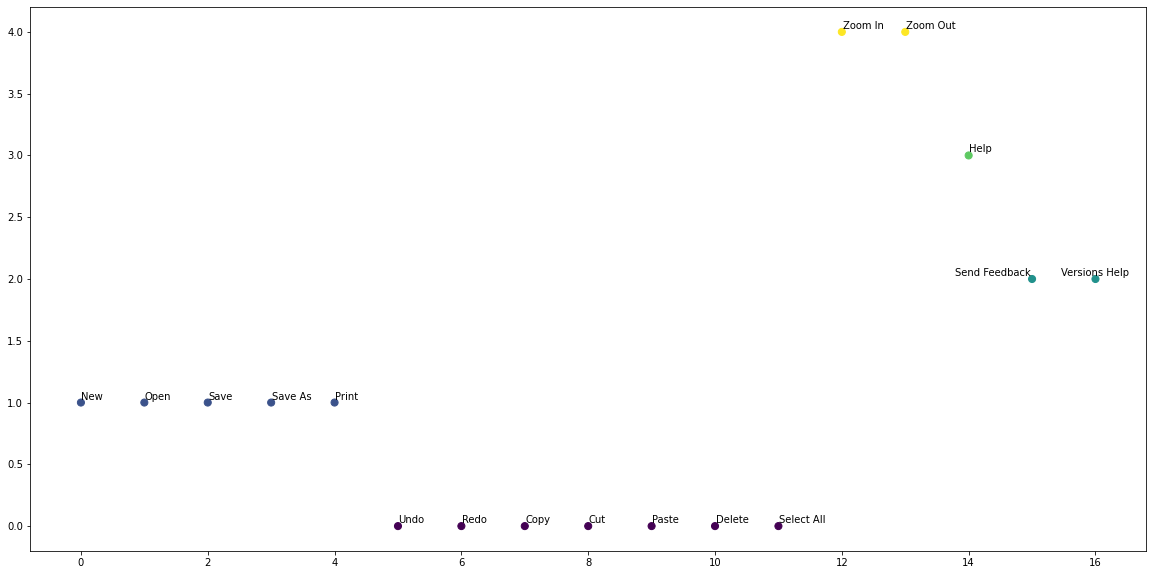

In [18]:
command_list = ['New', 'Open', 'Save', 'Save As', 'Print','Undo', 'Redo', 'Copy', 'Cut', 'Paste', 'Delete', 'Select All', 'Zoom In', 'Zoom Out', 'Help', 'Send Feedback', 'Versions Help']

number_of_nodes = len(command_list)
nodes_list_index = list(range(number_of_nodes))
n_clusters = int(np.ceil(np.log2(number_of_nodes)))

node_embeddings = np.array([model.wv.get_vector(i) for i in command_list])

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(node_embeddings) #kmeans
node_colors = kmeans.labels_


figure = plt.gcf() # get current figure
figure.set_size_inches(20, 10)
plt.scatter(nodes_list_index,node_colors,c=node_colors, s=50, cmap='viridis')
texts = [plt.text(nodes_list_index[i], node_colors[i], txt , ha='center', va='center') for i, txt in enumerate(command_list)]
adjust_text(texts) #adjusting annotations

In [ ]:
## TSNE

In [25]:
# Retrieve node embeddings and corresponding subjects
node_ids = list(model.wv.index_to_key)  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

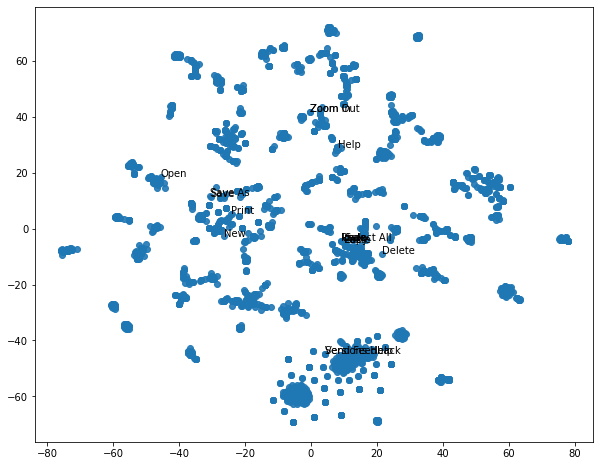

In [24]:
alpha=0.9
plt.figure(figsize=(10,8))
plt.scatter(node_embeddings_2d[:,0],
            node_embeddings_2d[:,1],
            cmap="jet", alpha=alpha)



for i, txt in enumerate(node_ids):
    if txt in command_list:
        plt.annotate(txt, (node_embeddings_2d[:,0][i], node_embeddings_2d[:,1][i]))

51

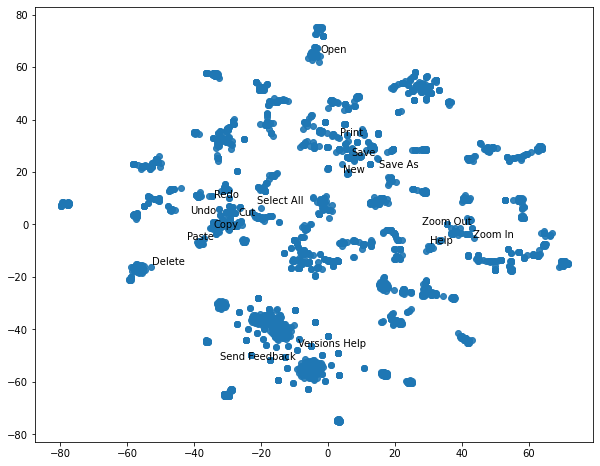

In [27]:
alpha=0.9
plt.figure(figsize=(10,8))
plt.scatter(node_embeddings_2d[:,0],
            node_embeddings_2d[:,1],
            cmap="jet", alpha=alpha)


texts = []



for i, txt in enumerate(node_ids):
    if txt in command_list:
        texts.append(plt.annotate(txt, (node_embeddings_2d[:,0][i], node_embeddings_2d[:,1][i])))

adjust_text(texts) #adjusting annotations

In [75]:
wordsim('Help', 'Send Feedback')

array([[0.36233255]], dtype=float32)

In [77]:
wordsim('Excel Help', 'Send Feedback')

array([[0.38091004]], dtype=float32)

In [79]:
wordsim('Versions Help', 'Send Feedback')

array([[0.99977964]], dtype=float32)

In [26]:
wordsim('Versions Help', 'Help')

array([[0.36333287]], dtype=float32)

In [28]:
wordsim('Convert Selected Simplified Chinese File', 'Convert Selected Simplified Chinese Text')

array([[0.96542656]], dtype=float32)

In [ ]:
#TODO: Add NLP in some stages!